# Supplementary code to arXiv:2402.13999


Suppose we have a feature map $\phi\colon\mathbf R^d \to\mathbf R^p$ on which we can perform ridge regression with $n$ samples $(x_i,y_i)$, $i=1,\ldots,n$. By the representer theorem we know that

$$
f(x) = \sum_{i=1}^n\alpha_i \phi(x)^\top\phi(x_i),
$$

so that minimizing

$$
\begin{split}
\sum_j (y_j - f(x_j))^2 + \lambda \sum_j (\phi(x_j)^\top \alpha)^2 &= \sum_j (y_j - \sum_{i=1}^n \phi(x_j)^\top\phi(x_i)\alpha_i)^2 + \lambda \sum_j (\phi(x_j)^\top \alpha)^2\\
& = \lVert y - \Phi^\top\Phi \alpha\rVert^2 + \lambda \lVert\Phi\alpha\rVert^2,
\end{split}
$$

with $\Phi:=(\phi(x_1),\cdots,\phi(x_n))\in\mathbf R^{p\times n}$, with respect to $\alpha$ yields

$$
\hat\alpha := (\Phi^\top\Phi + \lambda I)^{-1}y, \quad \hat f(x) = \phi(x)^\top\Phi (\Phi^\top\Phi + \lambda I)^{-1}y= \phi(x)^\top (\Phi \Phi^\top + \lambda I)^{-1}\Phi y.
$$

Our theorem from https://arxiv.org/abs/2402.13999 gives a theoretical prediction for the generalization error

$$
    \mathcal E_\mathrm{gen} := \mathbf E_{x',y'} (y' - \hat f(x'))^2 = \mathbf E_{x',y'} (y' - \phi(x')^\top\hat \alpha)^2 = \sigma^2 + \hat\alpha^\top\Omega\hat\alpha - 2 \psi^\top\hat \alpha,
$$

where

$$
    \mathbf E \phi(x)\phi(x)^\top = \Omega, \qquad \mathbf E \phi(x) = 0, \qquad \mathbf E \phi(x)y = \psi,\qquad \mathbf E y^2 = \sigma^2,
$$

in terms of the formula

$$
    \mathcal E_\mathrm{gen}^\mathrm{rmt}:=\frac{ \sigma^2 -  n\lambda m\psi^\top (M+\lambda M^2)\psi }{1-n(m\lambda)^2\operatorname{Tr} \Omega M\Omega M}.
$$

Here $M,m$ are defined by

$$
    \frac{1}{m(\lambda)} = \lambda + \operatorname{Tr} \Omega (1 + n m(\lambda)\Omega )^{-1}, \quad M(\lambda) := (\lambda + \lambda n m(\lambda)\Omega )^{-1},
$$


## Imports


In [4]:
! pip install icecream pyobsplot line_profiler -q
! apt-get install -y ca-certificates curl gnupg
! mkdir -p /etc/apt/keyrings
! curl -fsSL https://deb.nodesource.com/gpgkey/nodesource-repo.gpg.key | sudo gpg --dearmor -o /etc/apt/keyrings/nodesource.gpg
! echo "deb [signed-by=/etc/apt/keyrings/nodesource.gpg] https://deb.nodesource.com/node_18.x nodistro main" | sudo tee /etc/apt/sources.list.d/nodesource.list
! apt-get update
! apt-get install -y nodejs
! npm install -g npm
! npm install pyobsplot

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ca-certificates is already the newest version (20230311ubuntu0.22.04.1).
curl is already the newest version (7.81.0-1ubuntu1.16).
gnupg is already the newest version (2.2.27-3ubuntu2.1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
gpg: cannot open '/dev/tty': No such device or address
curl: (23) Failed writing body
deb [signed-by=/etc/apt/keyrings/nodesource.gpg] https://deb.nodesource.com/node_18.x nodistro main
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://deb.nodesource.com/node_18.x nodistro InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports

In [5]:
import numpy as np
import polars as pl
from icecream import ic
from pyobsplot import Obsplot, Plot, js
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from scipy.interpolate import interp1d
from scipy.integrate import quad_vec
from scipy.optimize import minimize_scalar
from tqdm.notebook import tqdm

op = Obsplot(renderer="jsdom")

## Sample Covariance + Regression Classes


In [6]:
class GaussianIntegral:
    """
    A utility class to compute gaussian integrals of functions of the form
    x -> f(mu + sigma * x) for a given function f. The integrals are precomputed
    on a grid and then interpolated using scipy's RegularGridInterpolator. For
    each function f, the computation is done only once and then cached. Besides
    the function f, the class also stores the integral of f' and f^2. The class
    is callable and returns the interpolated value of the integral for a given
    mu and sigma.

    Parameters
    ----------
    mu : tuple
        The range of mu values to consider
    sigma : tuple
        The range of sigma values to consider
    n_points : int
        The number of points to use for the grid
    """

    def __init__(self, sigma=(1e-8, 100), n_points=10_000):
        self.cache = {}
        self.sigma = sigma
        self.n_points = n_points

    def __call__(self, f, sigma=1, function="f"):
        """
        Compute the integral of f(sigma * x) for a given mu and sigma. The
        function f is assumed to be vectorized, i.e. it should accept an array
        of x values and return an array of f values. The integral is computed
        using scipy's quad function. The result is cached and interpolated using
        scipy's RegularGridInterpolator.

        Parameters
        ----------
        f : callable
            The function to integrate. Has to be a vectorized function with a name!
        mu : iterable or number (if iterable, should have the same length as sigma)
            The mean of the gaussian
        sigma : iterable or number (if iterable, should have the same length as mu)
            The standard deviation of the gaussian
        function : str
            The function to return. Can be 'f', 'fp' or 'f2'

        Returns
        -------
        float or array
            The integral of f(mu + sigma * x) for the given mu and sigma
        """
        if function not in ["f", "fp", "f2"]:
            raise ValueError("Invalid function")
        if f.__name__ not in self.cache:
            ic("Computing integral for", f.__name__)
            sigmas = np.linspace(*self.sigma, self.n_points)

            def gaussint(fun):
                g = (lambda x: x.numpy()) if isinstance(fun(0), tf.Tensor) else lambda x: x

                return quad_vec(
                    lambda x: g(fun(x)) * np.exp(-(x**2) / 2) / np.sqrt(2 * np.pi),
                    -np.inf,
                    np.inf,
                )[0]

            self.cache[f.__name__] = {
                "f": interp1d(sigmas, gaussint(lambda x: f(x * sigmas))),
                "fp": interp1d(sigmas, gaussint(lambda x: x * f(x * sigmas) / sigmas)),
                "f2": interp1d(sigmas, gaussint(lambda x: f(x * sigmas) ** 2)),
            }
            ic("Done computing integral for", f.__name__)

        return self.cache[f.__name__][function](sigma)


gaussian_integral = GaussianIntegral()

In [7]:
class SCov:
    """
    Deterministic equivalents to sample covariance matrices with population covariance matrix Omega

    Parameters
    ----------
    Omega : np.ndarray, shape=(p,p)
        The population covariance matrix
    eps : float
        The precision of the iterative algorithm to compute m(l,n)

    Attributes
    ----------
    OmegaEig : np.ndarray, shape=(p,)
        The eigenvalues of the population covariance matrix
    U : np.ndarray, shape=(p,p)
        The eigenvectors of the population covariance matrix

    Methods
    ----------
    m(l,n=n,m0=1) : float
        The deterministic equivalent to the averaged trace of the Gram resolvent $\check{G}$
        with regularization parameter $l$ and $n$ samples
    M(l,n=n) : np.ndarray, shape=(p,p)
        The deterministic equivalent to the resolvent $G$ with regularization parameter $l$ and $n$ samples
    """

    def __init__(self, Omega, eps=1e-8):
        assert Omega.shape[0] == Omega.shape[1] and len(Omega.shape) == 2
        self.Omega = Omega
        self.OmegaEig, self.U = np.linalg.eigh(Omega)
        self.p = Omega.shape[0]
        self.eps = eps
        self.m_cache = {}

    def _m(self, l, n=None, history=False, m0=1):
        n = self.p if n is None else n

        def iter_m(m):
            return 1 / (l + np.sum(self.OmegaEig / (n * m * self.OmegaEig + 1)))

        m1 = iter_m(m0)
        hist = [abs(m0 - m1)]
        while abs(m0 - m1) > self.eps:
            m0, m1 = m1, iter_m(m1)
            if history:
                hist.append(abs(m0 - m1))
        return [m1, hist] if history else m1

    def m(self, lamb, n=None, m0=None, verbose=False):
        """
        m(l,n=n) is the solution to the equation m = 1/(l+ <Omega@inv(1 + n/p*Omega*l*m)>)

        Parameters
        ----------
        l : float
            The regularization parameter
        n : int
            The number of samples
        history : bool
            Whether to return the history of the iterative algorithm
        m0 : float
            The initial guess for the iterative algorithm

        Returns
        -------
        float or list
            The solution to the equation m = 1/(l+ <Omega@inv(1 + n/p*Omega*l*m)>) or [m, history] if history=True
        """
        n = self.p if n is None else n
        if (lamb, n) in self.m_cache:
            if verbose:
                ic("Using cached value")
            return self.m_cache[(lamb, n)]
        else:
            if self.m_cache and not m0:
                closest_ln = min(
                    self.m_cache.keys(),
                    key=lambda x: (abs(x[0] - lamb) / lamb) ** 2 + (abs(x[1] - n) / n) ** 2,
                )
                m0 = self.m_cache[closest_ln]
                if verbose:
                    ic("Starting from cache", m0, closest_ln)
            elif not m0:
                if verbose:
                    ic("Starting from m0 = 1")
                m0 = 1
            (m, hist) = self._m(lamb, n=n, m0=m0, history=True)
            if verbose:
                ic(m0, m, len(hist))
            self.m_cache[(lamb, n)] = m
            return m

    def M(self, lamb, n=None, eigs=False):
        """
        M(l,n=n) is the deterministic equivalent to the resolvent $G$ with parameter $l$ and $n$ samples

        Parameters
        ----------
        l : float
            The regularization parameter
        n : int
            The number of samples
        eigs : bool
            Whether to return the eigenvalues of the resolvent or the resolvent itself

        Returns
        -------
        np.ndarray, shape=(p,p) or np.ndarray, shape=(p,)
            The deterministic equivalent to the resolvent $G$ with parameter $l$ and $n$ samples or its eigenvalues
        """
        n = self.p if n is None else n
        if eigs:
            return 1 / (n * lamb * self.m(lamb, n=n) * self.OmegaEig + lamb)
        else:
            return self.U @ np.diag(self.M(lamb, n=n, eigs=True)) @ self.U.T

In [8]:
class FeatureRidgeRegression:
    """
    A class to compute the generalization error of ridge regression with a given population covariance matrix Omega, label variance sigma**2 and label-feature covariance psi. If data is provided, the class can also compute the ridge regression vector. If test_data is provided, the class can also compute the empirical generalization error of the learned ridge regression vector.

    Parameters
    ----------
    Omega : np.ndarray, shape=(p,p)
        The population covariance matrix
    sigma : float
        The label variance
    psi : np.ndarray, shape=(p,)
        The label-feature covariance
    data : tuple
        A tuple (Phi, y) where Phi is the feature matrix of shape (p,n) and y is the target vector of shape (n,)
    test_data : tuple
        A tuple (Phi_test, y_test) where Phi_test is the test feature matrix of shape (p,n_test) and y_test is the test target vector of shape (n_test,)

    Methods
    ----------
    learningCurveEmp(l, n=None, repeats=1) : pl.DataFrame
        Compute the empirical generalization error of the learned ridge regression vector for different numbers of samples and regularization parameters. Requires data and test_data to be provided.
    genErrRMT(l, n=None) : float
        Compute the generalization error of ridge regression with regularization parameter l and n samples. Requires the population covariance matrix, label variance and label-feature covariance to be provided.
    learningCurveRMT(l, n=None) : pl.DataFrame
        Compute the generalization error of ridge regression with regularization parameter l and n samples for different numbers of samples and regularization parameters. Requires the population covariance matrix, label variance and label-feature covariance to be provided.
    """

    def __init__(self, Omega=None, sigma=None, psi=None, data=None, test_data=None, **kwargs):
        self.Omega, self.psi, self.sigma = Omega, psi, sigma
        assert self.Omega is not None and self.psi is not None and self.sigma is not None
        assert self.Omega.shape[0] == self.Omega.shape[1] == len(self.psi)
        if data is not None:
            self.Phi = data[0]
            self.y = data[1]
        if test_data is not None:
            self.Phi_test = test_data[0]
            self.y_test = test_data[1]
        self.p = self.Omega.shape[0]
        self.sc = SCov(self.Omega, **kwargs)
        self.UTpsi = self.sc.U.T @ self.psi

    @classmethod
    def empirical(cls, model, train_data=None, test_data=None, emp_avg_data=None, center=True):
        fmodel = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)
        features = {
            name: fmodel(data[0]).numpy()
            for (name, data) in [
                ("train", train_data),
                ("test", test_data),
                ("emp_avg", emp_avg_data),
            ]
        }
        y = {
            name: data[1]
            for (name, data) in [
                ("train", train_data),
                ("test", test_data),
                ("emp_avg", emp_avg_data),
            ]
        }
        if center:
            for name in ["train", "test", "emp_avg"]:
                features[name] -= features["emp_avg"].mean(axis=0, keepdims=True)
        Omega = features["emp_avg"].T @ features["emp_avg"] / features["emp_avg"].shape[0]
        psi = (features["emp_avg"] * y["emp_avg"][:, np.newaxis]).mean(axis=0)
        sigma = np.mean(y["emp_avg"] ** 2) ** 0.5
        return cls(
            Omega=Omega,
            psi=psi,
            sigma=sigma,
            data=(features["train"].T, y["train"]),
            test_data=(features["test"].T, y["test"]),
        )

    @classmethod
    def linearized(cls, model, train_data=None, test_data=None, emp_avg_data=None, avg=True):
        fmodel = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)
        features = {name: fmodel(data[0]).numpy() for (name, data) in [("train", train_data), ("test", test_data)]}
        sigma = np.mean(emp_avg_data[1] ** 2) ** 0.5
        x = emp_avg_data[0].reshape(emp_avg_data[0].shape[0], -1)
        Omega0 = x.T @ x / x.shape[0]
        psi = np.mean(x * emp_avg_data[1][:, np.newaxis], axis=0)

        for i in range(2, len(fmodel.layers)):
            try:
                f = fmodel.layers[i].activation
                W = fmodel.layers[i].weights[0].numpy()
            except AttributeError:
                raise ValueError("Unsupported Architecture")
            Omega1 = W.T @ Omega0 @ W
            if avg:
                std = np.mean(np.diag(Omega1)) ** 0.5
                fp = gaussian_integral(f, sigma=std, function="fp")
                f2 = gaussian_integral(f, sigma=std, function="f2")
                Omega0 = Omega1 * fp**2 + np.identity(W.shape[1]) * (f2 - fp**2 * std**2)
                psi = fp * W.T @ psi
            else:
                std = np.diag(Omega1) ** 0.5
                fp = gaussian_integral(f, sigma=std, function="fp")
                f2 = gaussian_integral(f, sigma=std, function="f2")
                Omega0 = np.diag(fp) @ (Omega1 - np.diag(np.diag(Omega1))) @ np.diag(fp) + np.diag(f2)
                psi = np.diag(fp) @ W.T @ psi
        return cls(
            Omega=Omega0,
            psi=psi,
            sigma=sigma,
            data=(features["train"].T, train_data[1]),
            test_data=(features["test"].T, test_data[1]),
        )

    def genErrEmp(self, lamb, n=None, repeats=1):
        """
        Empirical generalization error of ridge regression with regularization parameter l and n samples

        Parameters
        ----------
        lamb : float
            The regularization parameter
        n : int
            The number of samples
        repeats : int
            The number of times to average the computation of the generalization error

        Returns
        -------
        float
            The empirical generalization error for different numbers of samples and regularization parameters
        """
        rng = np.random.default_rng()
        errors = []
        for _ in range(repeats):
            idx = rng.choice(range(len(self.y)), size=n, replace=False)
            Xt, yt = self.Phi[:, idx], self.y[idx]
            sol = tf.linalg.lstsq(Xt.T, np.array([yt]).T, l2_regularizer=lamb)
            errors.append(np.mean((self.y_test - (self.Phi_test.T @ sol)[:, 0]) ** 2))
        return np.mean(errors)

    def genErrRMT(
        self,
        lamb=None,
        n=None,
        l_bounds=None,
        maxiter=50,
    ):
        """
        Deterministic generalization error of ridge regression with regularization parameter l and n samples. If lamb is not provided, the optimal regularization parameter is found using an optimization algorithm.

        Parameters
        ----------
        lamb : float (optional)
            The regularization parameter
        n : int (default: p)
            The number of samples
        l_bounds : tuple (optional)
            The range of regularization parameters to consider
        maxiter : int (default: 50)
            The maximum number of iterations for the optimization algorithm to find the optimal regularization parameter

        Returns
        -------
        float
            The deterministic generalization error for different numbers of samples and regularization parameters
        """

        n = self.p if n is None else n

        if lamb is None and l_bounds is None:
            raise ValueError("Either provide a value for lambda, or an optimization range")
        if lamb is None:

            def opt(x):
                return self.genErrRMT(lamb=x, n=n)

            min_val = minimize_scalar(opt, bounds=l_bounds, method="bounded", options={"maxiter": maxiter})
            return {"lamb": min_val.x, "genErrRMT": min_val.fun}

        ml = self.sc.m(lamb, n=n)
        Me = 1 / (n * lamb * ml * self.sc.OmegaEig + lamb)
        TrOmMOmM = np.sum(self.sc.OmegaEig**2 * Me**2)
        psiMlM2psi = np.sum(self.UTpsi**2 * (Me + lamb * Me**2))
        return (self.sigma**2 - n * lamb * ml * psiMlM2psi) / (1 - n * (ml * lamb) ** 2 * TrOmMOmM)

    def learningCurve(self, lambdas=None, ns=None, ns_emp=None, repeats=1):
        """
        Compute the learning curve of the ridge regression model for different regularization parameters and number of samples. If lambdas is not provided, the optimal regularization parameter is found using an optimization algorithm for the deterministic generalization error, and the same lambda is used for the empirical generalization error.

        Parameters
        ----------
        lambdas : list
            The regularization parameters to consider for the deterministic generalization error
        ns : list
            The number of samples to consider for the deterministic generalization error
        ns_emp : list
            The number of samples to consider for the empirical generalization error
        repeats : int
            The number of times to average the computation of the empirical generalization error

        Returns
        -------
        pl.DataFrame
            The learning curve of the ridge regression model for different regularization parameters and number of samples
        """
        if ns is None and ns_emp is None:
            raise ValueError("Provide either ns or ns_emp")

        ns = [] if ns is None else ns
        ns_emp = [] if ns_emp is None else ns_emp
        ns = np.unique(np.concatenate([ns, ns_emp])).astype(int)

        res = []
        for n in ns:
            if not lambdas:
                new_res = self.genErrRMT(n=n, l_bounds=(1e-5, 1e5))
                new_res["n"] = n
                if n in ns_emp:
                    new_res["genErrEmp"] = self.genErrEmp(lamb=new_res["lamb"], n=n, repeats=repeats)
                res.append(new_res)
            else:
                for ll in lambdas:
                    new_res = {"n": n, "lamb": ll}
                    if n in ns:
                        new_res["genErrRMT"] = self.genErrRMT(lamb=ll, n=n)
                    if n in ns_emp:
                        new_res["genErrEmp"] = self.genErrEmp(lamb=ll, n=n, repeats=repeats)
                    res.append(new_res)
        return pl.DataFrame(res).sort("n")

In [9]:
class SaveFeatures(keras.callbacks.Callback):
    def __init__(self, save_callback):
        self.log = dict()
        self.n_epochs = 0
        self.n_steps = 0
        self.save_callback = save_callback

    def save(self):
        if res := self.save_callback(self.model, n_epoch=self.n_epochs, n_step=self.n_steps):
            self.log[(self.n_epochs, self.n_steps)] = res

    def on_train_begin(self, logs=None):
        self.steps_per_epoch = self.n_steps

    def on_epoch_begin(self, epoch, logs=None):
        self.n_epochs = epoch
        self.n_steps = 0

    def on_train_batch_begin(self, batch, logs=None):
        self.save()
        self.n_steps += 1

    def on_train_end(self, logs=None):
        self.n_epochs += 1
        self.n_steps = 0
        self.save()

In [10]:
def rational_log_space(max_val, denom=10, num_val=100):
    return (np.unique(np.geomspace(1, max_val * denom + 1, num_val, dtype=int)) - 1) / denom


def rational_pow_space(max_val, denom=10, pow=2, num_val=100):
    return np.unique(np.round(np.linspace(0, (max_val * denom) ** (1 / pow), num_val) ** pow)) / denom


def choose(arr, num):
    return [list(arr)[i] for i in np.round(np.linspace(0, len(arr) - 1, num)).astype(int)]

## Data Import


In [11]:
def filter(images, labels, class_names, class_map):
    filtered_idx = [i for i, label in enumerate(labels) if class_names[label] in class_map]
    return images[filtered_idx], np.array([class_map[class_names[label]] for label in labels[filtered_idx]])


def getData(
    name="fashion-MNIST",
    class_map={"Shirt": -1, "T-shirt/top": -1, "Pullover": 1, "Coat": 1},
):
    if name == "fashion-MNIST":
        fashion_mnist = keras.datasets.fashion_mnist
        (
            (train_images, train_labels),
            (test_images, test_labels),
        ) = fashion_mnist.load_data()
        images = np.concatenate([train_images, test_images])
        labels = np.concatenate([train_labels, test_labels])
        class_names = [
            "T-shirt/top",
            "Trouser",
            "Pullover",
            "Dress",
            "Coat",
            "Sandal",
            "Shirt",
            "Sneaker",
            "Bag",
            "Ankle boot",
        ]
        return filter(images, labels, class_names, class_map)
    if name == "MNIST":
        mnist = keras.datasets.mnist
        (train_images, train_labels), (test_images, test_labels) = mnist.load_data()
        images = np.concatenate([train_images, test_images])
        labels = np.concatenate([train_labels, test_labels])
        class_names = list(range(10))
        return filter(images, labels, class_names, class_map)
    raise ValueError("Unsupported Dataset")

In [12]:
def normalize(images):
    mz = images - np.mean(images, axis=0)
    return mz / mz.std()


def random_split(prop, images, labels):
    rng = np.random.default_rng()
    choice = rng.choice(list(prop.keys()), p=list(prop.values()), size=len(labels))
    return {k: (images[choice == k], labels[choice == k]) for k in prop.keys()}


f_images, f_labels = getData(name="MNIST", class_map={i: (1 if i % 2 == 0 else -1) for i in range(10)})
f_images = normalize(f_images)
data = random_split({"test": 0.1, "train_reg": 0.25, "train_w": 0.25, "emp_cov": 0.4}, f_images, f_labels)

11490434/11490434 [==============================] - 2s 0us/step


In [ ]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data["test"][0][i], cmap=plt.cm.binary)
    plt.xlabel(data["test"][1][i])
plt.show()

## Model Def & Training


In [14]:
model_dim = 2352
n_epochs = 70
batch_size = 128
train_data = data["train_w"]
num_steps = np.ceil(len(train_data[1]) / batch_size)
n_callbacks = 70

model = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        keras.layers.Flatten(),
        keras.layers.Dense(2352, activation="relu", use_bias=False),
        keras.layers.Dense(2352, activation="relu", use_bias=False),
        keras.layers.Dense(1, use_bias=False),
    ]
)

model.compile(optimizer="adam", loss="mean_squared_error")


def save_callback(model, n_epoch=0, n_step=0):
    if n_epoch + n_step / num_steps not in rational_log_space(n_epochs, denom=num_steps, num_val=n_callbacks):
        return
    acc = model.evaluate(*data["test"])
    return {
        "reg": FeatureRidgeRegression.empirical(
            model,
            train_data=data["train_reg"],
            test_data=data["test"],
            emp_avg_data=data["emp_cov"],
        ),
        "loss": acc,
    }


model = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        keras.layers.Flatten(),
        keras.layers.Dense(model_dim, activation="relu", use_bias=False),
        keras.layers.Dense(model_dim, activation="relu", use_bias=False),
        keras.layers.Dense(1, use_bias=False),
    ]
)

model.compile(optimizer="adam", loss="mean_squared_error")

regressions = SaveFeatures(save_callback)
history = keras.callbacks.History()

model.fit(
    *train_data,
    epochs=n_epochs,
    validation_data=data["test"],
    batch_size=batch_size,
    verbose=1,
    shuffle=True,
    callbacks=[regressions, history],
)

Epoch 1/70
  6/138 [>.............................] - ETA: 8:09 - loss: 3.0923 

138/138 [==============================] - 111s 770ms/step - loss: 0.1896 - val_loss: 0.1880
Epoch 2/70
138/138 [==============================] - 15s 106ms/step - loss: 0.1275 - val_loss: 0.1239
Epoch 3/70
138/138 [==============================] - 12s 85ms/step - loss: 0.1069 - val_loss: 0.1082
Epoch 4/70
138/138 [==============================] - 8s 59ms/step - loss: 0.0891 - val_loss: 0.0958
Epoch 5/70
138/138 [==============================] - 8s 58ms/step - loss: 0.0793 - val_loss: 0.0918
Epoch 6/70
138/138 [==============================] - 4s 31ms/step - loss: 0.0626 - val_loss: 0.0818
Epoch 7/70
138/138 [==============================] - 4s 31ms/step - loss: 0.0521 - val_loss: 0.0816
Epoch 8/70
138/138 [==============================] - 5s 35ms/step - loss: 0.0455 - val_loss: 0.0775
Epoch 9/70
138/138 [==============================] - 4s 30ms/step - loss: 0.0405 - val_loss: 0.0819
Epoch 10/70
138/138 [==============================] - 4s 30ms/step - loss: 0.0429 - val_loss: 0

In [15]:
op(
    {
        "marks": [
            Plot.lineY(
                pl.DataFrame(history.history).with_columns(pl.Series("epoch", range(n_epochs))).melt(id_vars="epoch"),
                dict(x="epoch", y="value", stroke="variable"),
            )
        ],
        "title": "Training History",
        "color": {"legend": True, "type": "categorical"},
        "y": {"type": "log", "label": "loss"},
        "grid": True,
    }
)

## Real Data Feature Regression


In [16]:
regs = [0.1, 1, 10]
regsLin = [1, 10, 200]
nsRMT = np.unique(np.geomspace(10, 10_000, 200, dtype=int))
nsEmp = np.unique(np.geomspace(10, len(data["train_reg"][1]) / 2, 30, dtype=int))

In [17]:
linear_model = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        keras.layers.Flatten(),
        keras.layers.Dense(1, use_bias=False),
    ]
)
linear_model.compile(
    optimizer="adam",
    loss="mean_squared_error",
)
linear_regression = FeatureRidgeRegression.empirical(
    linear_model,
    train_data=data["train_reg"],
    test_data=data["test"],
    emp_avg_data=data["emp_cov"],
)
df_real_lin_reg = linear_regression.learningCurve(lambdas=regsLin, ns=nsRMT, ns_emp=nsEmp, repeats=3)

In [18]:
df_real_emp = pl.concat(
    [
        data["reg"]
        .learningCurve(
            lambdas=regs,
            ns=nsRMT,
            ns_emp=nsEmp,
            repeats=3,
        )
        .with_columns(
            [
                pl.lit(data["loss"]).alias("loss"),
                pl.lit(epoch).alias("epoch"),
                pl.lit(step).alias("step"),
                pl.lit(epoch + step / num_steps).alias("epoch+step"),
            ]
        )
        for (epoch, step), data in tqdm(choose(regressions.log.items(), 5))
    ],
    how="diagonal_relaxed",
)

  0%|          | 0/5 [00:00<?, ?it/s]

In [42]:
xstroke = dict(x="n", stroke=js("d=>`λ=${d.lamb.toFixed(1)}`"))
op(
    {
        "marks": [
            Plot.line(df_real_emp, xstroke | {"y": "genErrRMT", "fx": js("d=>parseFloat(`${d.epoch}.${d.step}`)")}),
            Plot.dot(df_real_emp, xstroke | {"y": "genErrEmp", "fx": js("d=>parseFloat(`${d.epoch}.${d.step}`)")}),
            Plot.line(df_real_lin_reg, xstroke | {"y": "genErrRMT", "fx": js("d=>'Linear Regression'")}),
            Plot.dot(df_real_lin_reg, xstroke | {"y": "genErrEmp", "fx": js("d=>'Linear Regression'")}),
            Plot.ruleY(df_real_emp, {"y": "loss", "fx": js("d=>parseFloat(`${d.epoch}.${d.step}`)"), "stroke": js("d=>'NN loss'")}),
        ],
        "color": {"legend": True, "type": "categorical"},
        "width": 1400,
        "height": 700,
        "x": {"type": "log", "label": "# Samples"},
        "y": {"domain": [0.04, 1.6], "label": "Generalization error", "type": "log"},
        "grid": True,
        "fx": {"label": "Epoch"},
        "title": "Generalization error of feature ridge regression",
        "subtitle": "The circles represent the empirical generalization error, the lines the deterministic equivalent. The colors encode the size of the regularization parameter of ridge regression. The features in the first plot are untrained random features, the other plots are trained features after some number of steps of gradient descent (the facet titles have the format 'epoch'.'step'). The horizontal lines represent the loss of the neural network on the test set.",
    }
)

In [20]:
df_real_det = pl.concat(
    [
        data["reg"]
        .learningCurve(
            lambdas=regs,
            ns=nsRMT,
            repeats=3,
        )
        .with_columns(
            [
                pl.lit(data["loss"]).alias("loss"),
                pl.lit(epoch).alias("epoch"),
                pl.lit(step).alias("step"),
                pl.lit(epoch + step / num_steps).alias("epoch+step"),
            ]
        )
        for (epoch, step), data in tqdm(regressions.log.items())
    ],
    how="diagonal_relaxed",
)

  0%|          | 0/60 [00:00<?, ?it/s]

In [21]:
op(
    {
        "marks": [
            Plot.line(
                df_real_det.sort("epoch+step", descending=True),
                dict(x="n", y="genErrRMT", stroke="epoch+step", fx="lamb", opacity=0.8),
            ),
        ],
        "color": {"legend": True, "label": "Epoch", "type": "log"},
        "width": 1400,
        "height": 700,
        "x": {"type": "log", "label": "# Samples"},
        "y": {"domain": [0, 1.2], "label": "Generalization error"},
        "grid": True,
        "fx": {"label": "λ"},
        "title": "Deterministic equivalent of the generalization error",
        "subtitle": "The plot shows the dynamics of the learning curves over the training epochs for various regularization parameters.",
    }
)

### Optimal $\lambda$


In [22]:
nsRMT = np.logspace(1, 3.5, 30).astype(int)
df_opt_lin = linear_regression.learningCurve(ns=nsRMT, ns_emp=nsRMT, repeats=3)
df_opt_emp = pl.concat(
    [
        data["reg"]
        .learningCurve(
            ns=nsRMT,
            ns_emp=nsRMT,
            repeats=3,
        )
        .with_columns(
            [
                pl.lit(data["loss"]).alias("loss"),
                pl.lit(epoch).alias("epoch"),
                pl.lit(step).alias("step"),
                pl.lit(epoch + step / num_steps).alias("epoch+step"),
            ]
        )
        for (epoch, step), data in tqdm(choose(regressions.log.items(), 5))
    ],
    how="diagonal_relaxed",
)

  0%|          | 0/5 [00:00<?, ?it/s]

In [23]:
op(
    {
        "marks": [
            Plot.line(df_opt_emp, dict(x="n", y="genErrRMT", opacity=1, fx="epoch+step")),
            Plot.dot(df_opt_emp, dict(x="n", y="genErrEmp", stroke="lamb", fx="epoch+step")),
            Plot.ruleY(df_opt_emp, dict(y="loss", fx="epoch+step", strokeDasharray=[5, 5])),
            Plot.line(df_opt_lin, dict(x="n", y="genErrRMT", fx=js("d=>'Linear Regression'"))),
            Plot.dot(df_opt_lin, dict(x="n", y="genErrEmp", stroke="lamb", fx=js("d=>'Linear Regression'"))),
        ],
        "x": {"type": "log", "label": "# Samples"},
        "y": {"domain": [0.04, 0.8], "label": "Generalization error", "type": "log"},
        "grid": True,
        "fx": {"label": "λ"},
        "width": 1000,
        "height": 700,
        "color": {"legend": True, "type": "log", "label": "λ"},
        "title": "Generalization error at optimal regularisation (real data)",
        "subtitle": "The plot show the generalisation error at optimally chosen regularization parameter λ∈[1e-5, 1e5] during the NN gradient descent and for ridge regression, together with the NN generalization loss (dashed). The optimal regularization parameters have been determined from the deterministic equivalents.",
    }
)

In [24]:
df_opt_det = pl.concat(
    [
        data["reg"]
        .learningCurve(ns=nsRMT)
        .with_columns(
            [
                pl.lit(data["loss"]).alias("loss"),
                pl.lit(epoch).alias("epoch"),
                pl.lit(step).alias("step"),
                pl.lit(epoch + step / num_steps).alias("epoch+step"),
            ]
        )
        for (epoch, step), data in tqdm(regressions.log.items())
    ],
    how="diagonal_relaxed",
)

  0%|          | 0/60 [00:00<?, ?it/s]

In [25]:
op(
    {
        "marks": [
            Plot.line(df_opt_lin, dict(x="n", y="genErrRMT", opacity=1, strokeDasharray=[5, 5])),
            Plot.line(df_opt_det, dict(x="n", y="genErrRMT", stroke="epoch+step", opacity=js("d=>d.epoch+d.step==0?1:.4"))),
        ],
        "x": {"type": "log", "label": "# Samples"},
        "y": {"domain": [0, 1.1], "label": "Generalization error"},
        "grid": True,
        "fx": {"label": "λ"},
        "color": {"legend": True, "type": "log", "label": "Epoch"},
        "title": "Generalization error at optimal regularisation",
        "subtitle": "The plot show the generalisation error at optimally chosen regularization parameter λ∈[1e-5, 1e5] during the NN gradient descent (initialization emphasized) and for ridge regression (dashed).",
    }
)

## Artificial Data Feature Regression


In [26]:
def gen_labels(x, model=None, source="model"):
    features = None
    if source == "model":
        feature_model = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)
        features = feature_model(x).numpy()
    elif source == "model_tanh":
        features = np.tanh(np.tanh(x.reshape(x.shape[0], -1) @ model.layers[1].weights[0].numpy()) @ model.layers[2].weights[0].numpy())
    elif source == "linear":
        features = x.reshape(x.shape[0], -1)
    elif source == "rf_keras":
        feature_model = keras.Sequential(
            [
                keras.Input(shape=(28, 28)),
                keras.layers.Flatten(),
                keras.layers.Dense(2352, activation="tanh", use_bias=False),
            ]
        )
        feature_model.compile(optimizer="adam", loss="mean_squared_error")
        features = feature_model(x).numpy()
    elif source == "rf":
        w = np.random.normal(0, 1, (x.shape[1] ** 2, 800)) / 800**0.5
        features = np.tanh(x.reshape(x.shape[0], -1) @ w)
    else:
        raise ValueError("Invalid Source")
    theta = np.random.normal(0, 1, features.shape[1])
    labels = np.dot(features, theta)
    labels -= labels.mean()
    labels /= labels.std()
    return labels

In [27]:
n_samples = 300_000
sample_dim = (28, 28)
flat_images = f_images.reshape(f_images.shape[0], -1)
pop_cov = flat_images.T @ flat_images / flat_images.shape[0]
pop_mean = flat_images.mean(axis=0)
images_artificial = np.random.multivariate_normal(pop_mean, pop_cov, n_samples).reshape(n_samples, *sample_dim)
labels_artificial = gen_labels(images_artificial, source="rf")

data_artificial = random_split({"test": 0.1, "train_reg": 0.1, "train_w": 0.6, "emp_cov": 0.2}, images_artificial, labels_artificial)

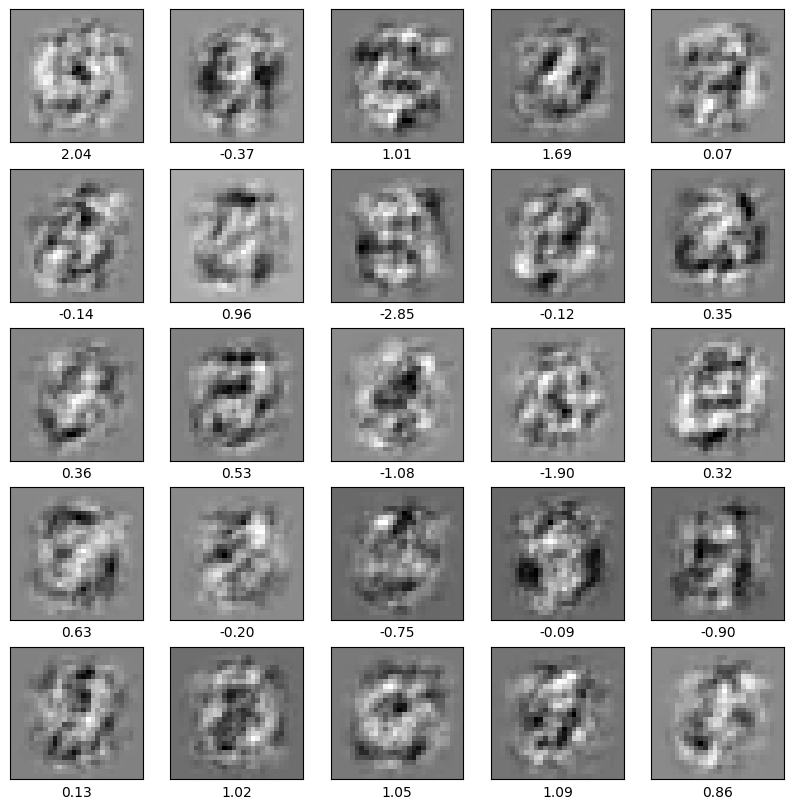

In [28]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data_artificial["test"][0][i], cmap=plt.cm.binary)
    plt.xlabel(f"{data_artificial['test'][1][i]:.2f}")
plt.show()

In [29]:
new_linear_model = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        keras.layers.Flatten(),
        keras.layers.Dense(1, use_bias=False),
    ]
)
new_linear_model.compile(
    optimizer="adam",
    loss="mean_squared_error",
)
new_linear_regression = FeatureRidgeRegression.empirical(
    new_linear_model, train_data=data_artificial["train_reg"], test_data=data_artificial["test"], emp_avg_data=data_artificial["emp_cov"]
)

In [30]:
n_epochs = 15
batch_size = 128
train_data = data_artificial["train_w"]
num_steps = np.ceil(len(train_data[1]) / batch_size)

new_model = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        keras.layers.Flatten(),
        keras.layers.Dense(
            800,
            activation="tanh",
            use_bias=False,
        ),
        keras.layers.Dense(
            700,
            activation="tanh",
            use_bias=False,
        ),
        keras.layers.Dense(1, use_bias=False),
    ]
)

new_model.compile(optimizer="adam", loss="mean_squared_error")


def lin_save_callback(model, n_epoch=0, n_step=0):
    if n_epoch + n_step / num_steps not in rational_log_space(n_epochs, denom=num_steps, num_val=20):
        return
    acc = model.evaluate(*data_artificial["test"])
    return {
        "reg_emp": FeatureRidgeRegression.empirical(
            model, train_data=data_artificial["train_reg"], test_data=data_artificial["test"], emp_avg_data=data_artificial["emp_cov"]
        ),
        "reg_lin": FeatureRidgeRegression.linearized(
            model, train_data=data_artificial["train_reg"], test_data=data_artificial["test"], emp_avg_data=data_artificial["emp_cov"], avg=False
        ),
        "loss": acc,
    }


lin_regressions = SaveFeatures(lin_save_callback)
history = keras.callbacks.History()

new_model.fit(
    *train_data,
    epochs=n_epochs,
    validation_data=data_artificial["test"],
    batch_size=batch_size,
    verbose=1,
    shuffle=True,
    callbacks=[lin_regressions, history],
)

Epoch 1/15
945/945 [==============================] - 1s 1ms/step - loss: 1.4549


ic| 'Computing integral for', f.__name__: 'tanh'
ic| 'Done computing integral for', f.__name__: 'tanh'


   4/1409 [..............................] - ETA: 1:15:08 - loss: 2.6612

1409/1409 [==============================] - 73s 45ms/step - loss: 0.0705 - val_loss: 0.0657
Epoch 2/15
1409/1409 [==============================] - 9s 7ms/step - loss: 0.0586 - val_loss: 0.0591
Epoch 3/15
1409/1409 [==============================] - 4s 3ms/step - loss: 0.0538 - val_loss: 0.0603
Epoch 4/15
1409/1409 [==============================] - 9s 7ms/step - loss: 0.0516 - val_loss: 0.0648
Epoch 5/15
1409/1409 [==============================] - 5s 3ms/step - loss: 0.0486 - val_loss: 0.0633
Epoch 6/15
1409/1409 [==============================] - 9s 6ms/step - loss: 0.0485 - val_loss: 0.0596
Epoch 7/15
1409/1409 [==============================] - 4s 3ms/step - loss: 0.0418 - val_loss: 0.0596
Epoch 8/15
1409/1409 [==============================] - 4s 3ms/step - loss: 0.0392 - val_loss: 0.0631
Epoch 9/15
1409/1409 [==============================] - 9s 7ms/step - loss: 0.0497 - val_loss: 0.0576
Epoch 10/15
1409/1409 [==============================] - 4s 3ms/step - loss: 0.0335 - val_l

In [31]:
op(
    {
        "marks": [
            Plot.lineY(
                pl.DataFrame(history.history).with_columns(pl.Series("epoch", range(n_epochs))).melt(id_vars="epoch"),
                dict(x="epoch", y="value", stroke="variable"),
            )
        ],
        "title": "Training History",
        "color": {"legend": True, "type": "categorical"},
        "y": {"type": "log", "label": "loss"},
        "grid": True,
    }
)

In [56]:
nsRMT = np.unique(np.geomspace(300, 5_000, 200, dtype=int))
nsEmp = np.unique(np.geomspace(300, 5_000, 15, dtype=int))
regs = [1, 10, 100]
regsReg = [0.1, 1, 10]

df_art_emp = pl.concat(
    [
        data["reg_emp"]
        .learningCurve(regs, ns=nsRMT, ns_emp=nsEmp, repeats=1)
        .join(data["reg_lin"].learningCurve(regs, ns=nsRMT).rename({"genErrRMT": "genErrRMTlin"}), on=("lamb", "n"), how="outer")
        .with_columns(
            [
                pl.lit(data["loss"]).alias("loss"),
                pl.lit(epoch).alias("epoch"),
                pl.lit(step).alias("step"),
                pl.lit(epoch + step / num_steps).alias("epoch+step"),
            ]
        )
        for (epoch, step), data in tqdm(choose(lin_regressions.log.items(), 4))
    ],
    how="vertical_relaxed",
)

  0%|          | 0/4 [00:00<?, ?it/s]

In [57]:
df_art_lin = new_linear_regression.learningCurve(regsReg, ns=nsRMT, ns_emp=nsEmp, repeats=5)

In [58]:
xstroke = dict(x="n", stroke=js("d=>`λ=${d.lamb.toFixed(1)}`"))

op(
    {
        "marks": [
            Plot.line(df_art_emp, xstroke | {"y": "genErrRMT", "fx": "epoch+step"}),
            Plot.line(
                df_art_emp,
                xstroke | {"y": "genErrRMTlin", "fx": "epoch+step", "strokeDasharray": "5,5"},
            ),
            Plot.dot(df_art_emp, xstroke | {"y": "genErrEmp", "fx": "epoch+step"}),
            Plot.line(
                df_art_lin,
                xstroke | {"y": "genErrRMT", "fx": js("d=>'Linear Regression'")},
            ),
            Plot.dot(
                df_art_lin,
                xstroke | {"y": "genErrEmp", "fx": js("d=>'Linear Regression'")},
            ),
            Plot.ruleY(
                df_art_emp,
                {"y": "loss", "fx": "epoch+step", "stroke": js("d=>'NN loss'")},
            ),
        ],
        "color": {"legend": True, "type": "categorical"},
        "width": 1400,
        "height": 700,
        "x": {"type": "log", "label": "# Samples"},
        "grid": True,
        "fx": {"label": "Epoch"},
        "title": "Generalization error of feature ridge regression",
        "y": {"label": "Generalization error", "type": "log", "domain": [0.05, 2]},
        "symbol": {"legend": True},
        "subtitle": "The circles represent the empirical generalization error, the lines the deterministic equivalent (solid with empirical and dashed with linearized covariance). The colors encode the size of the regularization parameter used for ridge regression. The features in the first plot are untrained random features, the other plots are trained features after some number of epochs of gradient descent. The horizontal lines represent the loss of the neural network on the test set.",
    }
)

### Optimal $\lambda$


In [35]:
nsRMT = np.geomspace(100, 20_000, 20, dtype=int)
df_art_opt_lin = new_linear_regression.learningCurve(ns=nsRMT, ns_emp=nsRMT, repeats=3)
df_art_opt_emp = pl.concat(
    [
        data["reg_emp"]
        .learningCurve(
            ns=nsRMT,
            ns_emp=nsRMT,
            repeats=3,
        )
        .with_columns(
            [
                pl.lit(data["loss"]).alias("loss"),
                pl.lit(epoch).alias("epoch"),
                pl.lit(step).alias("step"),
                pl.lit(epoch + step / num_steps).alias("epoch+step"),
            ]
        )
        for (epoch, step), data in tqdm(choose(lin_regressions.log.items(), 5))
    ],
    how="diagonal_relaxed",
)

  0%|          | 0/5 [00:00<?, ?it/s]

In [36]:
op(
    {
        "marks": [
            Plot.line(df_art_opt_emp, dict(x="n", y="genErrRMT", opacity=1, fx="epoch+step")),
            Plot.dot(df_art_opt_emp, dict(x="n", y="genErrEmp", stroke="lamb", fx="epoch+step")),
            Plot.ruleY(df_art_opt_emp, dict(y="loss", fx="epoch+step", strokeDasharray=[5, 5])),
            Plot.line(df_art_opt_lin, dict(x="n", y="genErrRMT", fx=js("d=>'Linear Regression'"))),
            Plot.dot(df_art_opt_lin, dict(x="n", y="genErrEmp", stroke="lamb", fx=js("d=>'Linear Regression'"))),
        ],
        "x": {"type": "log", "label": "# Samples"},
        "y": {"domain": [0.04, 0.6], "label": "Generalization error", "type": "log"},
        "grid": True,
        "fx": {"label": "λ"},
        "width": 1000,
        "height": 700,
        "color": {"legend": True, "type": "log", "label": "λ"},
        "title": "Generalization error at optimal regularisation (artificial data)",
        "subtitle": "The plot show the generalisation error at optimally chosen regularization parameter λ∈[1e-5, 1e5] during the NN gradient descent and for ridge regression, together with the NN generalization loss (dashed). The optimal regularization parameters have been determined from the deterministic equivalents.",
    }
)

In [37]:
df_art_opt_det = pl.concat(
    [
        data["reg_emp"]
        .learningCurve(ns=nsRMT)
        .with_columns(
            [
                pl.lit(data["loss"]).alias("loss"),
                pl.lit(epoch).alias("epoch"),
                pl.lit(step).alias("step"),
                pl.lit(epoch + step / num_steps).alias("epoch+step"),
            ]
        )
        for (epoch, step), data in tqdm(lin_regressions.log.items())
    ],
    how="diagonal_relaxed",
)

  0%|          | 0/18 [00:00<?, ?it/s]

In [38]:
op(
    {
        "marks": [
            Plot.line(df_art_opt_lin, dict(x="n", y="genErrRMT", opacity=1, strokeDasharray=[5, 5])),
            Plot.line(df_art_opt_det, dict(x="n", y="genErrRMT", stroke="epoch+step", opacity=js("d=>d.epoch+d.step==0?1:.4"))),
        ],
        "x": {"type": "log", "label": "# Samples"},
        "y": {"domain": [0.04, 0.4], "label": "Generalization error", "type": "log"},
        "grid": True,
        "fx": {"label": "λ"},
        "color": {"legend": True, "type": "log", "label": "Epoch"},
        "title": "Generalization error at optimal regularisation",
        "subtitle": "The plot show the generalisation error at optimally chosen regularization parameter λ∈[1e-5, 1e5] during the NN gradient descent (initialization emphasized) and for ridge regression (dashed).",
    }
)